# MILESTONE 2

IMDB dataset + Siraj's Network

In [1]:
import numpy as np
import tensorflow as tf

## Preprocessing Dataset

1. Removing punctuations
2. Generating word_to_int map
3. Coverting each review in ints
4. Padding each review with 0's and generating input of length 200

In [2]:
import re
from collections import Counter
#from nltk.corpus import stopwords

def preprocess(text):
    
    # Replace punctuation with tokens so we can use them in our model
    
    text = text.lower()
#     text = text.replace('.', ' <PERIOD> ')
#     text = text.replace(',', ' <PERIOD> ')
#     text = text.replace('"', ' <PERIOD> ')
#     text = text.replace(';', ' <PERIOD> ')
#     text = text.replace('!', ' <PERIOD> ')
#     text = text.replace('?', ' <PERIOD> ')
#     text = text.replace('(', ' <PERIOD> ')
#     text = text.replace(')', ' <PERIOD> ')
#     text = text.replace('--', ' <PERIOD> ')
#     text = text.replace('?', ' <PERIOD> ')
    
    text = text.replace('<br />', ' <PERIOD> ')
    text = text.replace('\\', ' <PERIOD> ')
    text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <PERIOD> ')
    text = text.replace(' <PERIOD> ', ' ')
    words = text.split()
    
    return words

def removing_noise(words):
    word_count = Counter(words)
    #stops = set(stopwords.words("english"))
    words_new = [word for word in words if (word_count[word]>5) #and (not word in stops)
                ]
    return words_new
    

sentence = []
score = []

In [3]:
review_ids = []
reviews = []
labels = []

import csv

filename = 'labeledTrainData.tsv'


with open(filename, 'r') as f:
    next(f)
    reader = csv.reader(f, delimiter='\t')
    row_count = 0
    for row in reader:
        review_ids.append(row[0])
        labels.append(int(row[1]) )
        reviews.append(row[2])

sentence.extend(reviews)
score.extend(labels)

In [4]:

import json
from pprint import pprint

with open('droom_google_tagged_data.json') as data_file:
    data = json.load(data_file)
    

sentiments = []
dialogues = []
for d in data['data']:
    #d['conversation']
    #d['conversation_id']
    conversation = d['conversation']
    c_id = d['conversation_id']
    for c in conversation:
        #c['sentiment']
        #c['text']
        #c['side']
        #c['timestamp']
        sentiment = float(c['sentiment'])
        sentiment = -1 if (sentiment < 0) else 1
        dialogue = c['text']
        dialogues.append(dialogue)
        sentiments.append(sentiment)

sentence.extend(dialogues)
score.extend(sentiments)


In [5]:
sentence_pp = []
words = []

for s in sentence:
    review_pp = preprocess(s)
    sentence_pp.append(review_pp)
    words.extend(review_pp)
    
words = removing_noise(words)



In [6]:
#Converting word to integers and making the vocabulary
vocab = set(words)
vocab_size = len(vocab)
words_count = Counter(words)
sorted_vocab = sorted(words_count, key = words_count.get, reverse = True)
word_to_int = {word:i for i,word in enumerate(sorted_vocab,1)}

#Converting each review in the form of integers
sentence_pp_ints = []
for review in sentence_pp:
    this_review_int = []
    for word in review:
        if word in vocab:
            this_review_int.append(word_to_int[word])
    sentence_pp_ints.append(this_review_int)

In [7]:
# from random import shuffle
# l = list(zip(reviews_pp_ints, labels))
# shuffle(l)

# reviews_pp_ints = [ item[0] for item in l]
# labels = [ [item[1]] for item in l]

In [8]:
max_seq_len = 200
features = np.zeros((len(sentence_pp_ints), max_seq_len), dtype=int)
for i, row in enumerate(sentence_pp_ints):
    features[i, :len(row)] = np.array(row[:max_seq_len] )

In [9]:
reviews = features[:len(reviews)]
dialogues = features[len(reviews):]

## Train Test Validation split

In [10]:
split_frac = 0.6
split_idx = int(len(dialogues)*split_frac)

dialogues_train, dialogues_val = dialogues[:split_idx], dialogues[split_idx:]
sentiments_train, sentiments_val = sentiments[:split_idx], sentiments[split_idx:]

test_idx = int(len(dialogues_val)*0.5)
dialogues_val, dialogues_test = dialogues_val[:test_idx], dialogues_val[test_idx:]
sentiments_val, sentiments_test = sentiments_val[:test_idx], sentiments_val[test_idx:]

In [11]:
split_frac = 0.6
split_idx = int(len(reviews)*split_frac)

reviews_train, reviews_val = reviews[:split_idx], reviews[split_idx:]
labels_train, labels_val = labels[:split_idx], labels[split_idx:]

test_idx = int(len(reviews_val)*0.5)
reviews_val, reviews_test = reviews_val[:test_idx], reviews_val[test_idx:]
labels_val, labels_test = labels_val[:test_idx], labels_val[test_idx:]

In [12]:
# split_frac = 0.8
# split_idx = int(len(features)*0.8)
# train_x, val_x = features[:split_idx], features[split_idx:]
# train_y, val_y = labels[:split_idx], labels[split_idx:]

# test_idx = int(len(val_x)*0.5)
# val_x, test_x = val_x[:test_idx], val_x[test_idx:]
# val_y, test_y = val_y[:test_idx], val_y[test_idx:]

In [13]:
train_x = []
val_x = []
train_y = []
val_y = []

train_x.extend(reviews_train)
train_x.extend(dialogues_train)

# val_x.extend(reviews_val)
# val_x.extend(dialogues_val)

train_y.extend(labels_train)
train_y.extend(sentiments_train)

# val_y.extend(labels_val)
# val_y.extend(sentiments_val)

In [14]:
from random import shuffle
train = list(zip(train_x, train_y))
shuffle(train)

train_x = [ item[0] for item in train]
train_y = [ [item[1]] for item in train]

labels_val = [ [item] for item in labels_val]
labels_test = [ [item] for item in labels_test]

sentiments_val = [ [item] for item in sentiments_val]
sentiments_test = [ [item] for item in sentiments_test]

In [15]:
# from random import shuffle
# val = list(zip(val_x, val_y))
# shuffle(val)

# val_x = [ item[0] for item in val]
# val_y = [ [item[1]] for item in val]

## Building Network

In [ ]:
input_size = 300
embed_size = 100
lstm_size = 256
lstm_layers = 1
batch_size = 500
hidden_nodes = 10


X = tf.placeholder(tf.int32, [None, None], name = 'inputs')
Y = tf.placeholder(tf.float32, [None, 1], name = 'labels')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

tf.set_random_seed(5)

In [ ]:
filename = 'Embedding_models/glove.6B.300d.txt'
def loadGloVe(filename):
    vocab = []
    embd = []
    file = open(filename,'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        vocab.append(row[0])
        embd.append(row[1:])
    print('Loaded GloVe!')
    file.close()
    return vocab,embd
vocab,embd = loadGloVe(filename)
vocab_size = len(vocab)
embedding_dim = len(embd[0])
embedding = np.asarray(embd)

In [16]:

# embedding = tf.Variable(tf.random_uniform((vocab_size+1, embed_size), -1, 1))
# embed = tf.nn.embedding_lookup(embedding, X)



############# NEW GLOVE ################

W = tf.Variable(tf.constant(0.0, shape=[vocab_size, embedding_dim]),
                trainable=False, name="W")
embedding_placeholder = tf.placeholder(tf.float32, [vocab_size, embedding_dim])
embedding_init = W.assign(embedding_placeholder)

#######################################



In [ ]:
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

cell = tf.contrib.rnn.MultiRNNCell([lstm]*lstm_layers)

#getting an initial state of zeros\n",
initial_state = cell.zero_state(batch_size, tf.float32)

outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state = initial_state)

#hidden_layer = tf.contrib.layers.fully_connected(outputs[:, -1], hidden_nodes, activation_fn=tf.nn.relu)
predictions = tf.contrib.layers.fully_connected(outputs[:, -1],1, activation_fn=tf.sigmoid)
#predictions,Y\n",

loss = tf.reduce_mean(tf.square(Y - predictions))
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

In [17]:
#Accuracy:
correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.float32), Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Training

In [18]:
n_epochs = 30

In [19]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
global_train_acc = []
global_test_acc = []

global_train_loss = []
global_test_loss = []

global_val_imdb_loss = []
global_val_chat_loss = []

saver = tf.train.Saver()
min_loss = 1.0

import time
start_time = time.time()
for e in range(n_epochs):
    state = sess.run(initial_state)
    iteration = 1
    loss_=0.0
    temp_train_loss = []
    for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
        feed = {X: x, Y: y, initial_state: state}

        state, loss_,  _ = sess.run([final_state, loss, optimizer], feed_dict=feed)

        if iteration%5==0:
            print("Epoch: {}/{}".format(e, n_epochs),
                  "Iteration: {}".format(iteration),
                  "Train loss: {:.5f}".format(loss_))
        temp_train_loss.append(loss_)
        
        '''
        if loss_<min_loss:
            min_loss = loss_
            save_path = saver.save(sess, "/model.ckpt")
        '''
        iteration+=1
    global_train_loss.append(np.mean(temp_train_loss))
    
    ##Validation loss IMDB
    val_loss = []
    val_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for x, y in get_batches(reviews_val, labels_val, batch_size):
        feed = {X: x,
                Y: y,
                initial_state: val_state}
        loss_, val_state = sess.run([loss, final_state], feed_dict=feed)
        val_loss.append(loss_)
    global_val_imdb_loss.append(np.mean(val_loss))
    
    ##Validation loss Chat
    val_loss = []
    val_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for x, y in get_batches(dialogues_val, sentiments_val, batch_size):
        feed = {X: x,
                Y: y,
                initial_state: val_state}
        loss_, val_state = sess.run([loss, final_state], feed_dict=feed)
        val_loss.append(loss_)
    global_val_chat_loss.append(np.mean(val_loss))
    
#sess.close()
    
print('Training Completed')
print('Total Time Taken: '+str(time.time()-start_time)+' sec' )

Epoch: 0/30 Iteration: 5 Train loss: 0.38035
Epoch: 0/30 Iteration: 10 Train loss: 0.29193
Epoch: 0/30 Iteration: 15 Train loss: 0.32201
Epoch: 0/30 Iteration: 20 Train loss: 0.30021
Epoch: 0/30 Iteration: 25 Train loss: 0.30190
Epoch: 0/30 Iteration: 30 Train loss: 0.30530
Epoch: 1/30 Iteration: 5 Train loss: 0.30568
Epoch: 1/30 Iteration: 10 Train loss: 0.27005
Epoch: 1/30 Iteration: 15 Train loss: 0.31691
Epoch: 1/30 Iteration: 20 Train loss: 0.29912
Epoch: 1/30 Iteration: 25 Train loss: 0.29873
Epoch: 1/30 Iteration: 30 Train loss: 0.30028
Epoch: 2/30 Iteration: 5 Train loss: 0.29874
Epoch: 2/30 Iteration: 10 Train loss: 0.25833
Epoch: 2/30 Iteration: 15 Train loss: 0.30011
Epoch: 2/30 Iteration: 20 Train loss: 0.27551
Epoch: 2/30 Iteration: 25 Train loss: 0.27786
Epoch: 2/30 Iteration: 30 Train loss: 0.28085
Epoch: 3/30 Iteration: 5 Train loss: 0.27670
Epoch: 3/30 Iteration: 10 Train loss: 0.23460
Epoch: 3/30 Iteration: 15 Train loss: 0.26524
Epoch: 3/30 Iteration: 20 Train loss: 

Epoch: 29/30 Iteration: 20 Train loss: 0.04550
Epoch: 29/30 Iteration: 25 Train loss: 0.04189
Epoch: 29/30 Iteration: 30 Train loss: 0.04413
Training Completed
Total Time Taken: 360.4311866760254 sec


## Test Accuracy

In [21]:
'''
saver = tf.train.Saver()
saver.restore(sess, "/model.ckpt")
'''

test_acc = []
test_state = sess.run(cell.zero_state(batch_size, tf.float32))
for ii, (x, y) in enumerate(get_batches(reviews_test, labels_test, batch_size), 1):
    feed = {X: x,Y: y,initial_state: test_state, keep_prob: 1}

    batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
    test_acc.append(batch_acc)
print("Test acc for movie reviews: {:.5f}".format(np.mean(test_acc)))

test_acc = []
test_state = sess.run(cell.zero_state(batch_size, tf.float32))
for ii, (x, y) in enumerate(get_batches(dialogues_test, sentiments_test, batch_size), 1):
    feed = {X: x,Y: y,initial_state: test_state, keep_prob: 1}

    batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
    test_acc.append(batch_acc)
print("Test acc for chat : {:.5f}".format(np.mean(test_acc)))

Test acc for movie reviews: 0.73600
Test acc for chat : 0.59800


## Training - Test Curve

[0.32195783, 0.29884675, 0.28273973, 0.25540069, 0.23617926, 0.20261253, 0.14270063, 0.10868407, 0.091201462, 0.071786895, 0.062545739, 0.057211924, 0.054398336, 0.053318668, 0.05258444, 0.051699281, 0.049349293, 0.047395498, 0.046660595, 0.046678189, 0.044291239, 0.043390792, 0.0426699, 0.041656047, 0.042603947, 0.04330194, 0.043237947, 0.047744997, 0.048177555, 0.043771639]
[0.25003272, 0.2527003, 0.26595965, 0.27262005, 0.28181821, 0.20710063, 0.19411764, 0.21110389, 0.21291578, 0.2088474, 0.2066139, 0.22041114, 0.21599157, 0.22860813, 0.23370969, 0.22160463, 0.22585921, 0.22510557, 0.22210319, 0.21999626, 0.22337258, 0.22198172, 0.22888088, 0.23899105, 0.23830895, 0.24449888, 0.23063929, 0.24003787, 0.22933006, 0.23404746]
[0.80078173, 0.8000378, 0.79934043, 0.79984182, 0.80880016, 0.71073753, 0.65490556, 0.65837491, 0.65273929, 0.65136904, 0.67185026, 0.66672599, 0.64787459, 0.64951217, 0.66423476, 0.65197384, 0.64613032, 0.65200555, 0.63907182, 0.63725513, 0.64364433, 0.63824135,

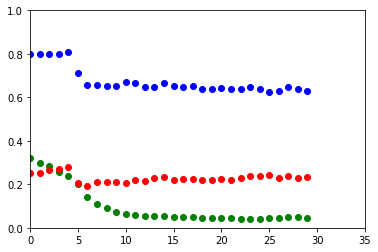

In [22]:
print(global_train_loss)
print(global_val_imdb_loss)
print(global_val_chat_loss)
import matplotlib.pyplot as plt
%matplotlib inline 
plt.ion()
x = range(30) 
plt.axis([0,len(x)+5,0,1])
plt.plot(x,global_train_loss,'go',x,global_val_imdb_loss,'ro',x,global_val_chat_loss,'bo')
plt.show()

#print('Minimum Testing Loss: '+str(np.min(global_test_loss)) )